# Problem description

You are to predict whether a company will go bankrupt in the following year, based on financial attributes of the company.

Perhaps you are contemplating lending money to a company, and need to know whether the company
is in near-term danger of not being able to repay.


## Goal

## Learning objectives

- Demonstrate mastery on solving a classification problem and presenting
the entire Recipe for Machine Learning process in a notebook.
- We will make suggestions for ways to approach the problem
    - But there will be little explicit direction for this task.
- It is meant to be analogous to a pre-interview task that a potential employer might assign
to verify your skill

# Import modules

In [1]:
## Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn

import os
import math
import seaborn as sns
%matplotlib inline

#Metrics
from sklearn.metrics import precision_score, f1_score, recall_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

#Model
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost.sklearn import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

import warnings
warnings.filterwarnings(action="ignore")

In [2]:
# !pip install imbalanced-learn

In [3]:
# !pip install missingno

# API for students

In [4]:
## Load the bankruptcy_helper module

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

# Import bankruptcy_helper module
import bankruptcy_helper
%aimport bankruptcy_helper

helper = bankruptcy_helper.Helper()

# Get the data

The first step in our Recipe is Get the Data.

- Each example is a row of data corresponding to a single company
- There are 64 attributes, described in the section below
- The column `Bankrupt` is 1 if the company subsequently went bankrupt; 0 if it did not go bankrupt
- The column `Id` is a Company Identifier

In [5]:
# Data directory
DATA_DIR = "./Data"

if not os.path.isdir(DATA_DIR):
    DATA_DIR = "../resource/asnlib/publicdata/bankruptcy/data"

data_file = "5th_yr.csv"
data = pd.read_csv( os.path.join(DATA_DIR, "train", data_file) )

target_attr = "Bankrupt"

n_samples, n_attrs = data.shape
print("Date shape: ", data.shape)

Date shape:  (4818, 66)


## Have a look at the data

We will not go through all steps in the Recipe, nor in depth.

But here's a peek

In [6]:
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt,Id
0,0.025417,0.41769,0.0568,1.1605,-126.39,0.41355,0.025417,1.2395,1.16500,0.51773,...,0.049094,0.85835,0.12322,5.6167,7.4042,164.310,2.2214,1.334,0,4510
1,-0.023834,0.2101,0.50839,4.2374,22.034,0.058412,-0.027621,3.6579,0.98183,0.76855,...,-0.031011,1.01850,0.069047,5.7996,7.7529,26.446,13.802,6.4782,0,3537
2,0.030515,0.44606,0.19569,1.565,35.766,0.28196,0.039264,0.88456,1.05260,0.39457,...,0.077337,0.95006,0.25266,15.049,2.8179,104.730,3.4852,2.6361,0,3920
3,0.052318,0.056366,0.54562,10.68,438.2,0.13649,0.058164,10.853,1.02790,0.61173,...,0.085524,0.97282,0,6.0157,7.4626,48.756,7.4863,1.0602,0,1806
4,0.000992,0.49712,0.12316,1.3036,-71.398,0,0.001007,1.0116,1.29210,0.50288,...,0.001974,0.99925,0.019736,3.4819,8.582,114.580,3.1854,2.742,0,1529


Pretty *unhelpful* !

What are these mysteriously named features ?

## Description of attributes

This may still be somewhat unhelpful for those of you not used to reading Financial Statements.

But that's partially the point of the exercise
- You can *still* perform Machine Learning *even if* you are not an expert in the problem domain
    - That's what makes this a good interview exercise: you can demonstrate your thought process even if you don't know the exact meaning of the terms
- Of course: becoming an expert in the domain *will improve* your ability to create better models
    - Feature engineering is easier if you understand the features, their inter-relationships, and the relationship to the target

Let's get a feel for the data
- What is the type of each attribute ?


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4818 entries, 0 to 4817
Data columns (total 66 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   X1        4818 non-null   object 
 1   X2        4818 non-null   object 
 2   X3        4818 non-null   object 
 3   X4        4818 non-null   object 
 4   X5        4818 non-null   object 
 5   X6        4818 non-null   object 
 6   X7        4818 non-null   object 
 7   X8        4818 non-null   object 
 8   X9        4818 non-null   float64
 9   X10       4818 non-null   object 
 10  X11       4818 non-null   object 
 11  X12       4818 non-null   object 
 12  X13       4818 non-null   float64
 13  X14       4818 non-null   object 
 14  X15       4818 non-null   object 
 15  X16       4818 non-null   object 
 16  X17       4818 non-null   object 
 17  X18       4818 non-null   object 
 18  X19       4818 non-null   float64
 19  X20       4818 non-null   float64
 20  X21       4818 non-null   obje

You may be puzzled:
- Most attributes are `object` and *not* numeric (`float64`)
- But looking at the data via `data.head()` certainly gives the impression that all attributes are numeric

Welcome to the world of messy data !  The dataset has represented numbers as strings.
- These little unexpected challenges are common in the real-word
- Data is rarely perfect and clean

So you might want to first convert all attributes to numeric

**Hint**
- Look up the Pandas method `to_numeric`
    - We suggest you use the option `errors='coerce'`
    

# Evaluating your project

We will evaluate your submission on a test dataset that we provide
- It has no labels, so **you** can't use it to evaluate your model, but **we** have the labels
- We will call this evaluation dataset the "holdout" data

Let's get it

In [8]:
holdout_data = pd.read_csv( os.path.join(DATA_DIR, "holdout", '5th_yr.csv') )

print("Data shape: ", holdout_data.shape)
holdout_data.head()

Data shape:  (1092, 65)


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,Id
0,0.20839,0.26185,0.41039,2.5692,69.704,0,0.20839,2.819,1.641,0.73815,...,0.193390,0.28231,0.81043,0,52.04,4.6463,58.171,6.2747,5.0017,699
1,-0.19877,0.9368,-0.15579,0.83309,-57.414,0,-0.19877,0.067309,0.93406,0.063054,...,-0.159470,-3.1524,1.20510,0,56.348,1.3163,364.730,1.0007,4.202,539
2,0.35741,0.57153,0.34081,1.5991,4.4819,0,0.35741,0.74968,2.6993,0.42847,...,0.160800,0.83415,0.86775,0,8.6285,7.8131,76.926,4.7448,29.896,867
3,0.024312,0.45219,0.011469,1.0393,-831.06,0.006914,0.031273,1.2114,0.88188,0.54781,...,0.193770,0.044381,0.82091,0.29244,21.306,3.4388,120.850,3.0202,1.2661,595
4,0.075494,0.088948,0.56492,7.6065,74.299,0,0.10304,10.243,2.1253,0.91105,...,0.037832,0.082864,0.95227,0,15.437,8.391,14.685,24.855,6.0797,632


We will evaluate your model on the holdout examples using metrics
- Accuracy
- Recall
- Precision

From our lecture: we may have to make a trade-off between Recall and Precision.

Our evaluation of your submission will be partially based on how you made (and described) the trade-off.

You may assume that it is 5 times worse to *fail to identify a company that will go bankrupt*
than it is to fail to identify a company that won't go bankrupt.

# Your model

Time for you to continue the Recipe for Machine Learning on your own.



## What has been done now

In previous steps, we already covered severl topics in Recipe
* We framed the problem: Trying to predict whether company bankrupt in the following year(classification problem)
* We got the data, and had a peak

Now I will continue following the steps in the Recipe

## Define performance measure

Since this is a classification problem, we will mainly use accuracy, recall, and precision as performance metrics


## Create a test set and put it aside

Since we already had the holdout dataset, we don't need to do anything here

In [9]:
from sklearn.utils import shuffle
data = shuffle(data)
data.reset_index(inplace=True, drop=True)

In [10]:
size = int(len(data)*0.9)

train_data = data[:size]
test_data=data[size:]

train_data.set_index('Id')
test_data.set_index('Id')

train_data.shape
test_data.shape

#Below is created for testing MyModel
test_data_copy=data[size:]
test_data_copy.drop(columns=['Bankrupt'],inplace=True)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt
Id,,,,,,,,,,,,,,,,,,,,,
1928,0.015278,0.76807,0.064291,1.3279,-26.481,-0.28076,0.015954,0.30196,1.31210,0.23193,...,0.019955,0.065872,1.00380,2.4662,8.5514,41.642,54.5490,6.6912,1.7741,1
1584,0.017368,0.73665,-0.30504,0.57982,-83.196,0.0248,0.021947,0.3575,1.79640,0.26335,...,0.009521,0.065948,0.98794,0,18.99,6.3711,147.5100,2.4744,3.1022,0
3757,0.008738,0.29392,0.32163,2.2758,-17.438,0,0.015283,2.4022,1.44030,0.70608,...,0.017027,0.012375,0.98950,0.002141,3.7346,7.9125,63.8870,5.7132,3.3788,0
4348,-0.005854,0.3925,-0.096661,0.64048,-88.539,0.016821,-0.002231,1.5478,1.03210,0.6075,...,0.031068,-0.009635,0.96893,0.20352,14.904,4.9655,157.1400,2.3228,0.75441,0
2206,0.075006,0.45146,0.17451,1.8278,35.729,0,0.090546,1.215,0.99283,0.54854,...,0.103610,0.13674,0.91119,0.39539,14.091,7.8749,77.5070,4.7093,1.6153,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3117,0.20497,0.29214,0.6133,3.0993,44.789,1.0513,0.2398,1.8508,1.07830,0.54071,...,0.072585,0.37908,0.92741,0,14.1,5.0226,32.5680,11.207,34.626,0
2993,0.067682,0.45975,0.53226,2.1655,92.114,0,0.083558,1.1751,2.11080,0.54025,...,0.034334,0.12528,0.96062,0,516.61,4.5812,78.9700,4.622,190.99,0
3173,0.073071,0.6408,0.093552,1.146,-132.04,-0.089694,0.065998,0.55898,1.11960,0.35819,...,0.106850,0.204,0.89315,0,2.4411,4.4582,208.0100,1.7547,4.2327,0


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt
Id,,,,,,,,,,,,,,,,,,,,,
2589,0.12012,0.23294,0.54554,3.6133,50.063,0.2,0.14931,2.9808,1.09570,0.69437,...,0.087337,0.17299,0.91266,0.034836,5.3627,6.8195,44.461,8.2095,6.975,0
3633,0.017311,0.33013,0.028772,1.0904,-51.357,0.02166,0.021437,1.6372,1.02500,0.54048,...,0.024352,0.032028,0.97565,0.022039,6.9732,12.925,76.566,4.7672,2.3231,0
5323,0.054832,0.9107,0.043986,1.0483,-7.3864,0,0.079277,0.098057,5.11540,0.0893,...,0.028398,0.61402,0.98455,0,36.171,6.4976,64.981,5.617,112.89,0
2288,0.1998,0.059067,0.60562,11.253,98.53,0.37884,0.25183,15.248,1.18140,0.90067,...,0.153530,0.22184,0.84647,0,7.8741,6.3548,12.521,29.151,5.135,0
3602,0.010651,0.13599,0.49443,4.6358,808.44,0,0.012486,6.3534,0.31508,0.86401,...,0.028903,0.012327,0.96079,0,?,0.66371,157.540,2.3169,0.85252,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2836,0.0276,0.85121,0.021854,1.0263,-9.9878,-0.058814,0.026613,0.12588,1.04120,0.10715,...,0.039604,0.25759,0.96040,0.1905,26.108,2.0333,203.080,1.7973,10.134,0
5373,-0.17638,1.0488,-0.39296,0.6023,-211.04,-0.31236,-0.17638,-0.046553,0.63130,-0.048826,...,-0.369940,3.6123,1.21500,0,10871,1.8111,571.280,0.63891,1.5593,0
3468,0.17956,0.10431,0.52183,6.7268,369.92,0,0.21988,8.5868,0.70404,0.89569,...,0.279170,0.20047,0.70026,0.014725,?,4.261,47.240,7.7264,1.819,0


(4336, 66)

(482, 66)

## Exploratory Data Analysis

### Visualize Data to Gain Insights
First thing, let's analysis the count of bankruptcy since it is the reason of our quest

In [11]:
train_data = train_data.apply(pd.to_numeric, errors='coerce')
# train_data.info()

In [12]:
train_data.isnull().sum().sum()

3352

<Figure size 1152x432 with 0 Axes>

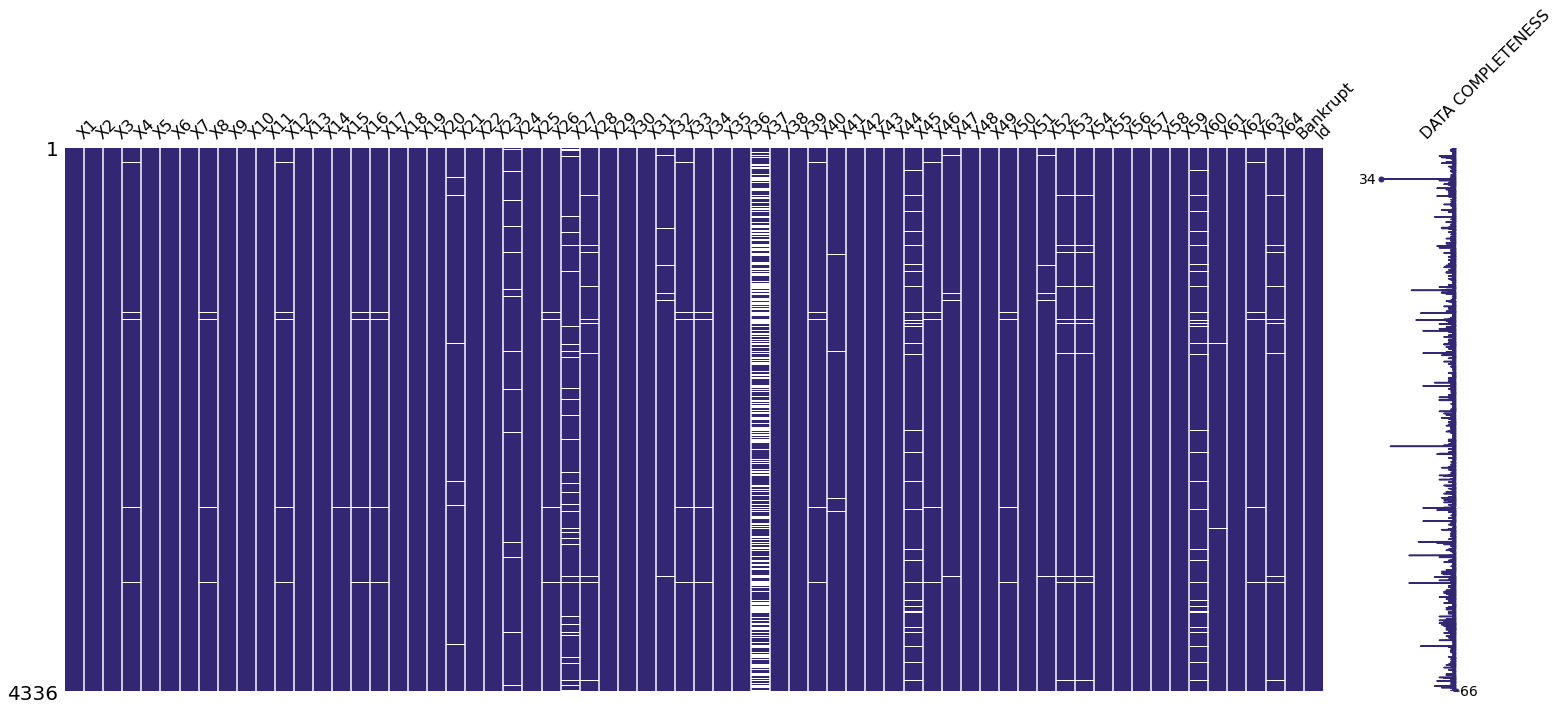

In [13]:
import missingno as msno # for missing value visualization

plt.figure(figsize=(16,6))
msno.matrix(train_data,labels = True, color=(0.20,0.15,0.45));

From the above visualization, we ca see that after converting object to numbers we are missing some values in the dataset. Some features, especially X37 missed almost half of the original data. Although we're imputing the missing data in later steps, for X37 it seems like a better option is to just drop this feature.

For next step, I will impute the training data set.

In [14]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
train_data = pd.DataFrame(imputer.fit_transform(train_data))

In [15]:
train_data.isnull().sum().sum() # Check missing values after imputation

0

In [16]:
train_data.columns = data.columns

In [17]:
train_data.drop(['X37'], axis = 1,inplace=True)

In [18]:
test_data = test_data.apply(pd.to_numeric, errors='coerce')
test_data = pd.DataFrame(imputer.fit_transform(test_data),columns=data.columns)
test_data.drop(['X37'], axis = 1,inplace=True)

In [19]:
train_data['Bankrupt'].value_counts()

0.0    4062
1.0     274
Name: Bankrupt, dtype: int64

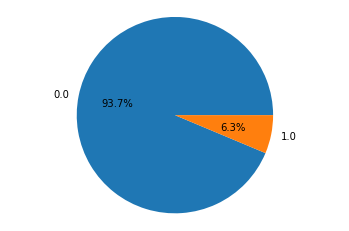

In [20]:
labels = train_data['Bankrupt'].astype('category').cat.categories.tolist()
counts = train_data['Bankrupt'].value_counts()
sizes = [counts[var_cat] for var_cat in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=False) #autopct is show the % on plot
ax1.axis('equal')
plt.show();

We can see that our target: Bankruptcy is imbalanced. Over 90% of the training data shows there's no bankruptcy in the following year and only 6.4% showed Bankruptcy. 

Next, I want to use heatmap to check the correlation between features

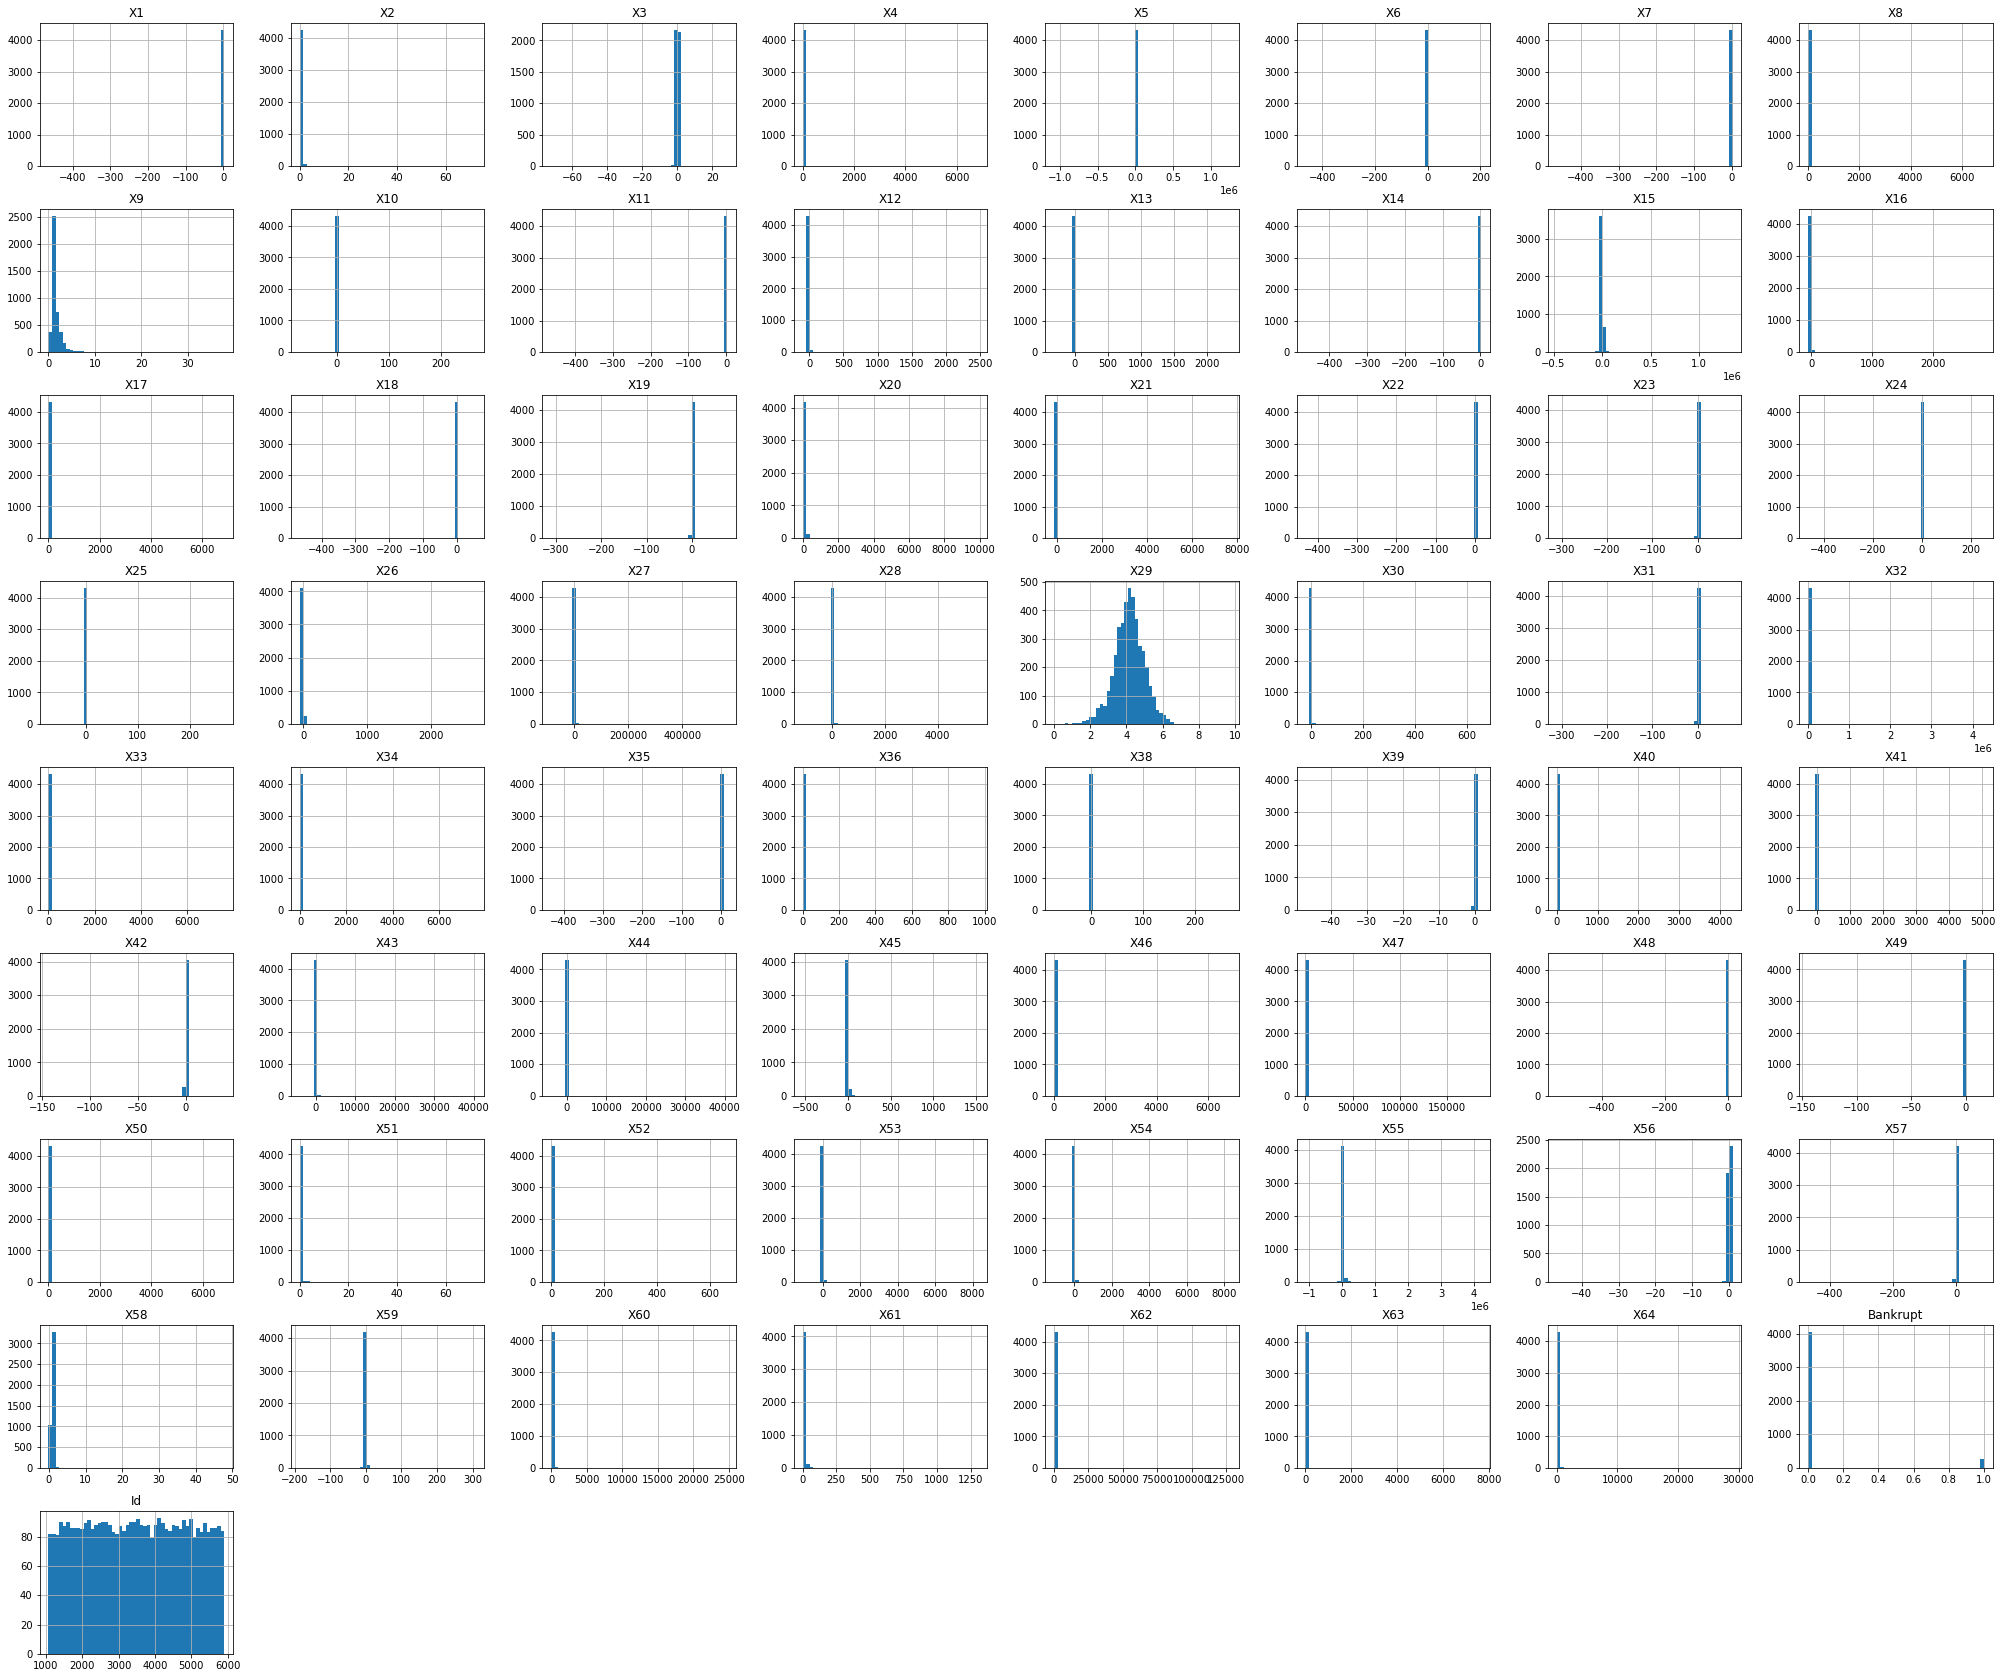

In [21]:
train_data.hist(figsize = (35,30), bins = 50)
plt.show();

<AxesSubplot:>

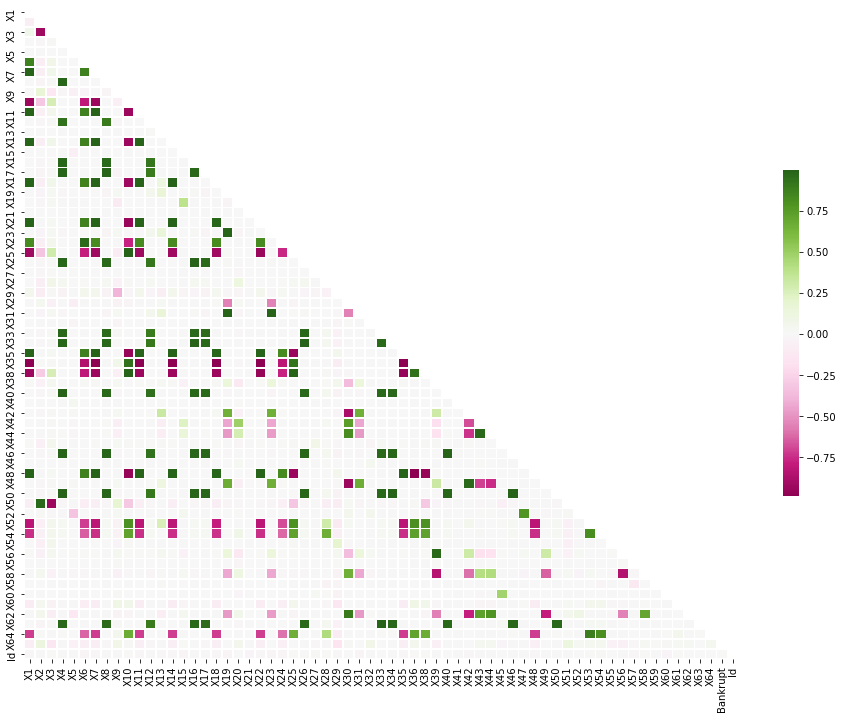

In [22]:
fig, ax = plt.subplots(figsize=(16,12)) 
corr = train_data.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

 
sns.heatmap(corr, mask=mask,
            square=False, linewidths=.5, cbar_kws={"shrink": .5},cmap='PiYG')

This heatmap shows that just like the assumption, there are a lot of highly correlated pairs of features from our 63 features.
If we look at the feature description, it's easy to find that many features contains the following :

* Total Assests
* Sales
* Total Liabilities

Sometimes features could have the same value in their denominators, so they will be positive correlated, for example:

* X1 & X6 -- net profit / total assets and retained earning / total assest

Or sometimes features could have above value in numerator and other features having the same value in the denominator, causing them to be negatively correlated, for example:

* X9 & X23 -- sales /total assets and net profit / sales

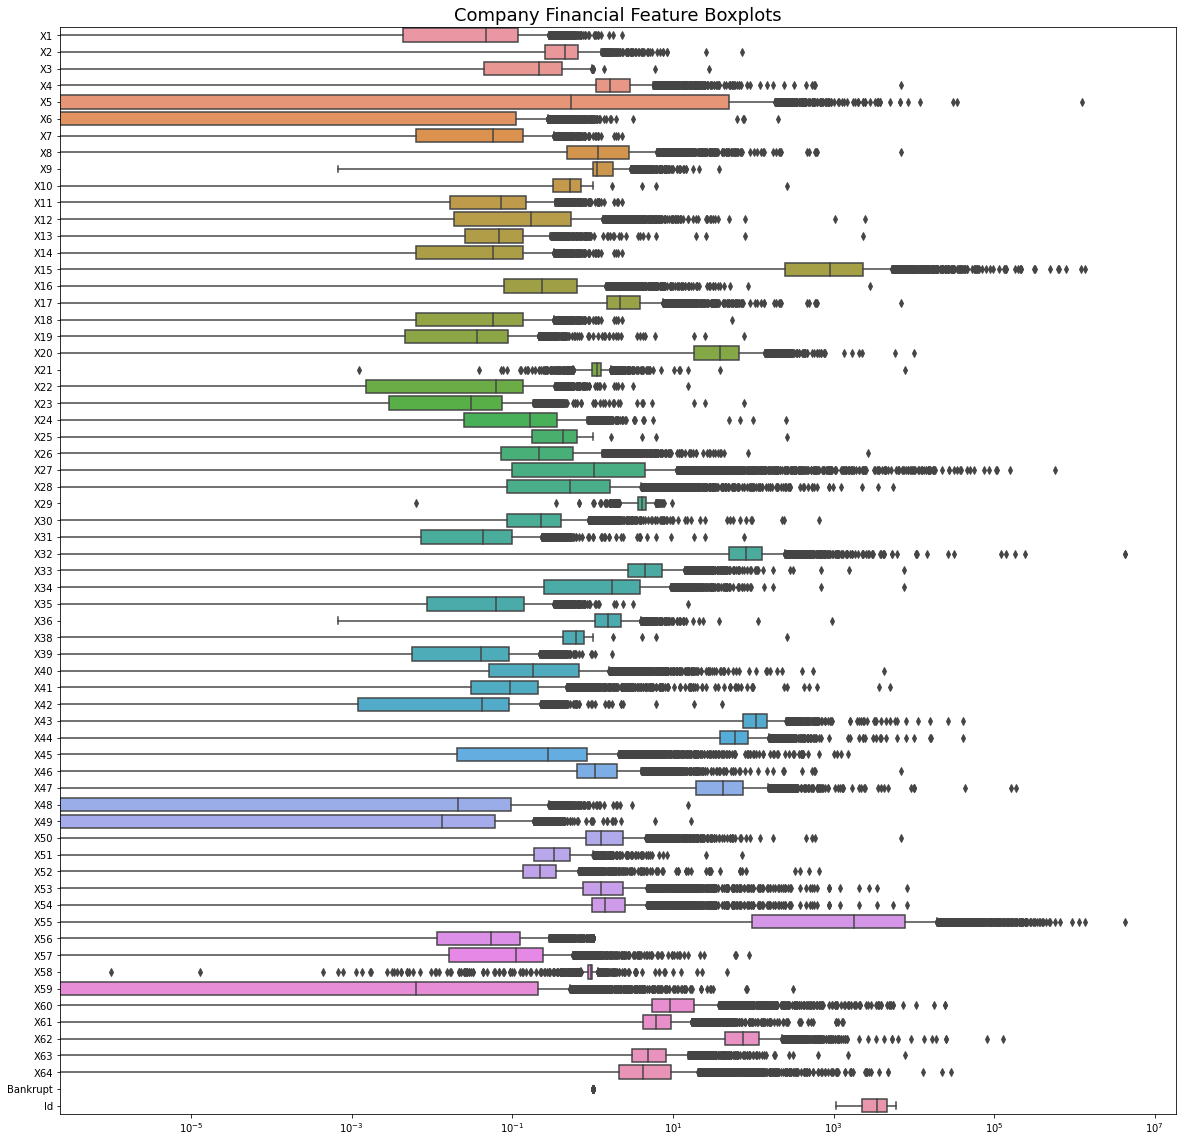

In [23]:
plt.figure(figsize = (20,20))
ax =sns.boxplot(data = train_data, orient="h")
ax.set_title('Company Financial Feature Boxplots', fontsize = 18)
ax.set(xscale="log")
plt.show();

The box plot clearly showed that the features have different scales and there are quite some outliers in certain features. We will need to scale the data and maybe drop the extreme outliers. 

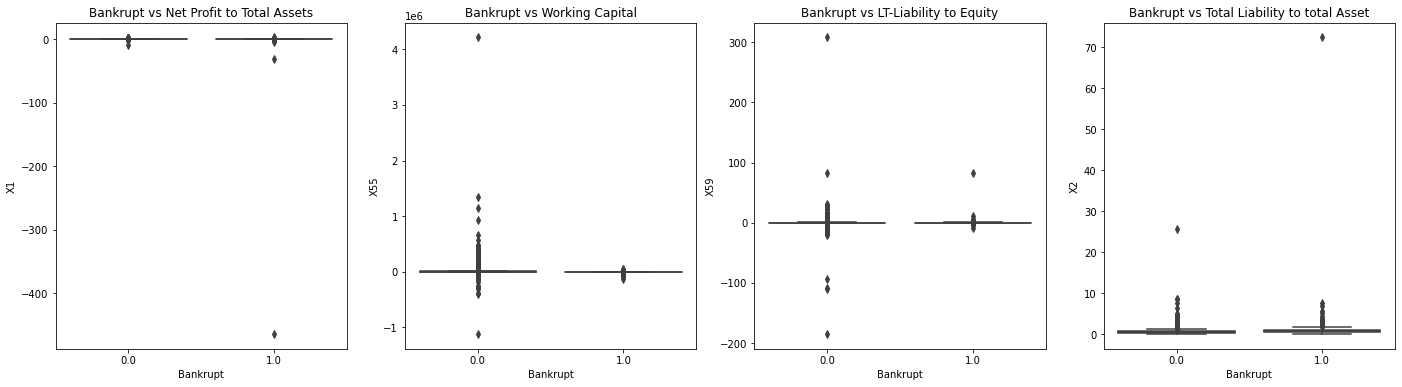

In [24]:
f, axes = plt.subplots(ncols=4, figsize=(24,6))

sns.boxplot(x='Bankrupt', y="X1", data=train_data, ax=axes[0])
axes[0].set_title('Bankrupt vs Net Profit to Total Assets')

sns.boxplot(x='Bankrupt', y="X55", data=train_data, ax=axes[1]) 
axes[1].set_title('Bankrupt vs Working Capital')


sns.boxplot(x='Bankrupt', y="X59", data=train_data, ax=axes[2])
axes[2].set_title('Bankrupt vs LT-Liability to Equity')


sns.boxplot(x='Bankrupt', y="X2", data=train_data, ax=axes[3])  
axes[3].set_title('Bankrupt vs Total Liability to total Asset') 

plt.show();

In the above cell, I picked 4 features which highlights 
* Net Profit / Total Asset
* Working capital
* Long Term Liability / Equity
* Liability / Asset 

For each boxplot, we can't really tell the difference btw Bankrupy and Not Bankrupt. However, it does reveal how extreme some outliers are.Look at Net profit / Total Asset, for Bankrupted company there's an outlier at -400.

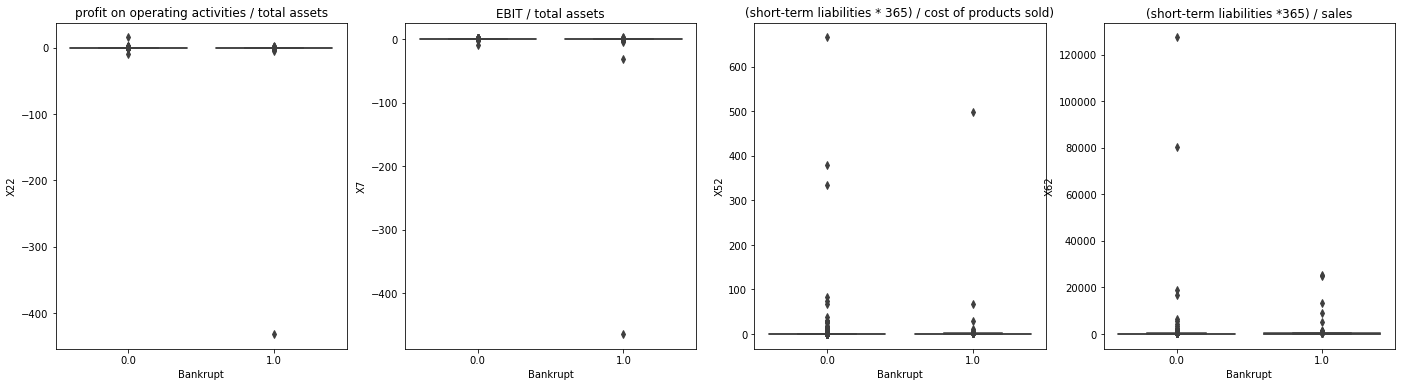

In [25]:
f, axes = plt.subplots(ncols=4, figsize=(24,6))

sns.boxplot(x='Bankrupt', y="X22", data=train_data, ax=axes[0])
axes[0].set_title('profit on operating activities / total assets')

sns.boxplot(x='Bankrupt', y="X7", data=train_data, ax=axes[1]) 
axes[1].set_title('EBIT / total assets')


sns.boxplot(x='Bankrupt', y="X52", data=train_data, ax=axes[2])
axes[2].set_title('(short-term liabilities * 365) / cost of products sold)')


sns.boxplot(x='Bankrupt', y="X62", data=train_data, ax=axes[3])  
axes[3].set_title('(short-term liabilities *365) / sales') 

plt.show();

Again, we only found that there's pretty extreme outliers for each of the features selected, for the above cell I chose the features that includes more details on cash flows. For example, EBIT, Cost of Good Sold and so on. 

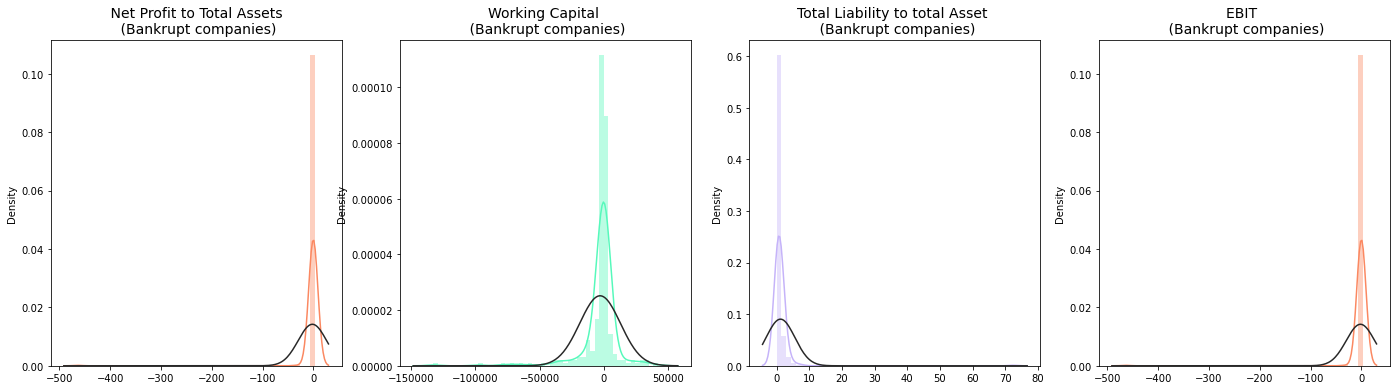

In [26]:
from scipy.stats import norm
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(24, 6))

cash_flow = train_data['X1'].loc[train_data['Bankrupt'] == 1].values
sns.distplot(cash_flow,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title(' Net Profit to Total Assets \n (Bankrupt companies)', fontsize=14)

working_cap = train_data['X55'].loc[train_data['Bankrupt'] == 1].values
sns.distplot(working_cap ,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('Working Capital \n (Bankrupt companies)', fontsize=14)


debt_ratio = train_data['X2'].loc[train_data['Bankrupt'] == 1].values
sns.distplot(debt_ratio,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('Total Liability to total Asset \n (Bankrupt companies)', fontsize=14)

EBIT = train_data['X7'].loc[train_data['Bankrupt'] == 1].values
sns.distplot(EBIT,ax=ax4, fit=norm, color='#FB8861')
ax4.set_title('EBIT \n (Bankrupt companies)', fontsize=14)

plt.show();

For the above plot, we only picked out the Bankrupted companies to figure out what distributions they would have on the features including Net Profit, Working Capital, Debt and Earnings before Interest and Tax. Not surprisingly, Profit, Working Capital and EBIT have long tails on the negative side, while the debt has long tail on the positive side. For a company to have negative earning, negative working capital, negative revenue, and outstanding debt, the financial state of that company would be concerning. 

Here we're not saying that all companies that satisfy above criteras are companies with higher chance to go bankrupt, many startups are like this but still turned out to be great companies with steady revenue. We will dive in on prediction of bankruptcy based on financial features later.

For comparison, I also plotted the above features for companies that did not go bankrupt, and the result is quite clear that the tail for each distributions are so much shorter and the variance is so much smaller.

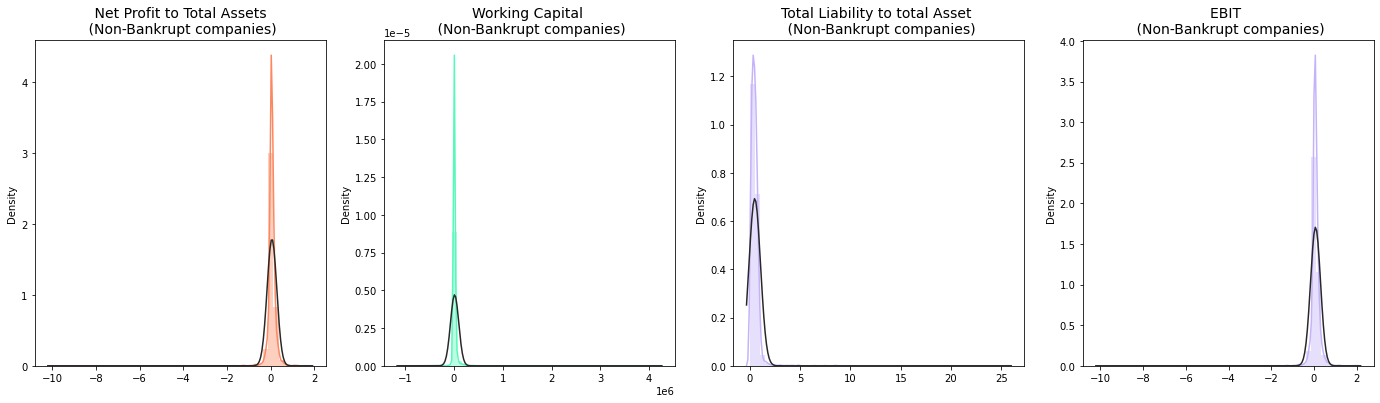

In [27]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(24, 6))

cash_flow = train_data['X1'].loc[train_data['Bankrupt'] == 0].values
sns.distplot(cash_flow,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title(' Net Profit to Total Assets \n (Non-Bankrupt companies)', fontsize=14)

working_cap = train_data['X55'].loc[train_data['Bankrupt'] == 0].values
sns.distplot(working_cap ,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('Working Capital \n (Non-Bankrupt companies)', fontsize=14)


debt_ratio = train_data['X2'].loc[train_data['Bankrupt'] == 0].values
sns.distplot(debt_ratio,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('Total Liability to total Asset \n (Non-Bankrupt companies)', fontsize=14)

EBIT = train_data['X7'].loc[train_data['Bankrupt'] == 0].values
sns.distplot(EBIT,ax=ax4, fit=norm, color='#C5B3F9')
ax4.set_title('EBIT \n (Non-Bankrupt companies)', fontsize=14)

plt.show();

In [28]:
y_train = train_data['Bankrupt']
X_train = train_data.drop(columns=['Bankrupt'])

In [29]:
y_test = test_data['Bankrupt']
X_test = test_data.drop(columns=['Bankrupt'])

## Prepare the data(Preprocessing)

In earlier steps, we already handled 

* the inconsistent data types(converting to numeric)
* the missing data (used KNN imputer)

There isn't any categorical features that need further transformation, so what remains is just scaling

As seen before, the dataset contains outliers. Since the dataset is small, it's not a good idea to simply remove the outliers(especially when there's a lot of outliers, judging from the boxplot). Instead, we scale each feature.

For this step, we want to scale the features, I chose Standard Scaler in case we need to do the Principal Component Analysis later, because I don't want to scale the 'Bankrupt' column and the 'Id' column, I will just set y_train and drop these two columns from the train_data to make the X_train.

### Scaling

In [30]:
from sklearn.preprocessing import StandardScaler
trans = StandardScaler()
X_train = pd.DataFrame(trans.fit_transform(X_train),columns=X_train.columns)

In [31]:
X_train.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,Id
0,0.011108,0.186677,-0.093232,-0.037090,-0.001817,-0.027606,0.009402,-0.048339,-0.201952,-0.064172,...,-0.048809,0.007273,0.051904,0.333960,-0.079727,0.663534,-0.053228,-0.024358,-0.063429,-1.123713
1,0.011403,0.161583,-0.374132,-0.044180,-0.004076,0.010035,0.010250,-0.047817,0.161054,-0.056770,...,-0.062492,0.007283,0.034555,-0.039987,-0.064360,-0.109151,-0.014471,-0.059756,-0.061269,-1.371308
2,0.010182,-0.192020,0.102492,-0.028106,-0.001457,0.006980,0.009307,-0.028596,-0.105860,0.047529,...,-0.052649,0.000259,0.036261,-0.039662,-0.086818,-0.075384,-0.049335,-0.032568,-0.060819,0.192714
3,0.008117,-0.113285,-0.215646,-0.043605,-0.004289,0.009053,0.006828,-0.036628,-0.411825,0.024305,...,-0.034235,-0.002626,0.013760,-0.009127,-0.070375,-0.139944,-0.010456,-0.061029,-0.065088,0.618088
4,0.019561,-0.066195,-0.009403,-0.032352,0.000661,0.006980,0.019957,-0.039756,-0.441259,0.010416,...,0.060899,0.016563,-0.049401,0.019966,-0.071572,-0.076207,-0.043657,-0.040995,-0.063688,-0.923622


In [32]:
from sklearn import metrics

model = RandomForestClassifier()
model.fit(X_train, y_train)
importance = model.feature_importances_ 
for i,v in enumerate(importance):
    print('X%0d, Score: %.5f' % (i+1,v))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

X1, Score: 0.01552
X2, Score: 0.01082
X3, Score: 0.01425
X4, Score: 0.01911
X5, Score: 0.01295
X6, Score: 0.01119
X7, Score: 0.01293
X8, Score: 0.01040
X9, Score: 0.01500
X10, Score: 0.00987
X11, Score: 0.01318
X12, Score: 0.01167
X13, Score: 0.01347
X14, Score: 0.01432
X15, Score: 0.01817
X16, Score: 0.01855
X17, Score: 0.01089
X18, Score: 0.01223
X19, Score: 0.01123
X20, Score: 0.01100
X21, Score: 0.02251
X22, Score: 0.01934
X23, Score: 0.01404
X24, Score: 0.02662
X25, Score: 0.01124
X26, Score: 0.01911
X27, Score: 0.03937
X28, Score: 0.01330
X29, Score: 0.01755
X30, Score: 0.01198
X31, Score: 0.00995
X32, Score: 0.01160
X33, Score: 0.01059
X34, Score: 0.01585
X35, Score: 0.02987
X36, Score: 0.01508
X37, Score: 0.01420
X38, Score: 0.03753
X39, Score: 0.02554
X40, Score: 0.02904
X41, Score: 0.01453
X42, Score: 0.01280
X43, Score: 0.01421
X44, Score: 0.01675
X45, Score: 0.03753
X46, Score: 0.01239
X47, Score: 0.01148
X48, Score: 0.01237
X49, Score: 0.01264
X50, Score: 0.01305
X51, Scor

<BarContainer object of 64 artists>

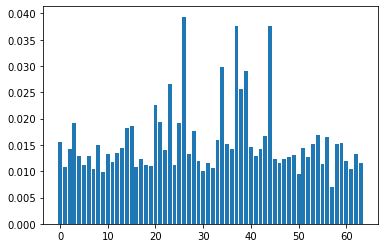

In [33]:
plt.bar([x for x in range(len(importance))], importance)
plt.show()

We can see from the graph that there're couple features having relative high feature importance score, next I would like to see what features are considered having high importance score, hoping to gain more insights or just understand the data a little better.

In [34]:
for i,v in enumerate(importance):
    if v >= 0.025:
        print('X%0d, Score: %.5f' % (i+1,v))

X24, Score: 0.02662
X27, Score: 0.03937
X35, Score: 0.02987
X38, Score: 0.03753
X39, Score: 0.02554
X40, Score: 0.02904
X45, Score: 0.03753


Features with high importance score:
* X22 profit on operating activities / total assets
* X24 gross profit (in 3 years) / total assets
* **X27 profit on operating activities / financial expenses**
* X35 profit on sales / total assets
* **X38 constant capital / total assets**
* X40 (current assets - inventory - receivables) / short-term liabilities
* **X45 net profit / inventory**

Due to the  stochastic nature of the algorithm or evaluation procedure, the importance score varies. Ideally, we should consider running the example a few times and compare the average outcome. But here I highlighted the two features that have highest importance score.

Taking a closer look at all features listed here, many features are linked to **profit**. But because these features all points to profits, they might have high correlations as well. 

In [35]:
for i,v in enumerate(importance):
    if v < 0.01:
        print('X%0d, Score: %.5f' % (i+1,v))

X10, Score: 0.00987
X31, Score: 0.00995
X51, Score: 0.00949
X58, Score: 0.00706


Features with low importance score:
* X30 (total liabilities - cash) / sales
* X31 (gross profit + interest) / sales
* X51 short-term liabilities / total assets
* X58 total costs /total sales

The common place for features with low importance score is not that obvious, only that liability showed up twice. This is not saying that these features doesn't provide valuable insight on a company's financial state, it's just that based on the data, these features are not as important as others.

## Dealing with imbalanced data

Before we jump into training the model, there's the problem with imbalanced data. Previously we saw that this dataset is highly skewed toward no Bankruptcy. We need to figure out a way to balance the dataset before proceed. 

The challenge of working with imbalanced information is that most machine learning models will ignore, and in turn have poor performance on, the minority class, although in this case it is the minority class, predicting 'Bankruptcy' that is most important and valuable for us.

Therefore I used the data augmentation technique for the minority class and is referred to as the Synthetic Minority Oversampling Technique, or SMOTE for short, to oversample the Bankruptcy cases.

The pipeline below implements the combination of SMOTE and Random Undersampling, first applying SMOTE to bring the minority class distribution to 10 percent of the majority class, then using RandomUnderSampler to bring the majority class down to 50 percent more than the minority class

In [36]:
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

over = SMOTE(random_state = 42,sampling_strategy=0.5)
#under = RandomUnderSampler(sampling_strategy=1.0)
#steps = [('o', over), ('u', under)]
steps = [('o', over)]
pipe = Pipeline(steps=steps)
X_train_re,y_train_re = pipe.fit_resample(X_train,y_train)

In [37]:
y_train_re.value_counts()

0.0    4062
1.0    2031
Name: Bankrupt, dtype: int64

## Dimensionality Reduction(PCA)

Before training the model, let's address the issue that there are features that are highly correlated. According to the feature description list, we can see that many features have repeated variables in them. Therefore, in order to improve the performance of the model we need to either remove a number of features or using PCA to reduce the dimensionality. 

Here I presented the dimensionality reduction using PCA.

In [38]:
y_test = test_data['Bankrupt']
X_test = test_data.drop(columns=['Bankrupt'])

In [39]:
X_test = pd.DataFrame(trans.fit_transform(X_test),columns=train_data.columns[:-1])

Here we performed the same imputation and scaling on X_test

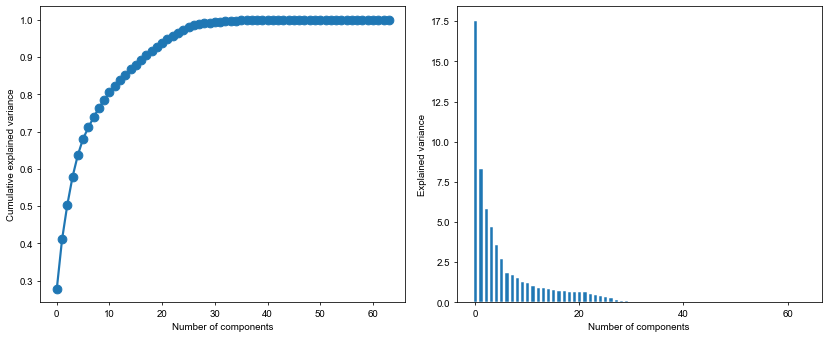

In [40]:
from sklearn.decomposition import PCA,SparsePCA,KernelPCA,NMF

pca = PCA().fit(X_train_re)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=70, facecolor='w', edgecolor='k')
ax0, ax1 = axes.flatten()

sns.set('talk', palette='colorblind')

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)

ax0.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
ax0.set_xlabel('Number of components')
ax0.set_ylabel('Cumulative explained variance');

ax1.bar(range(X_train_re.shape[1]),pca.explained_variance_)
ax1.set_xlabel('Number of components')
ax1.set_ylabel('Explained variance');

plt.tight_layout()
plt.show();

In [41]:
n_PCA_95 = np.size(np.cumsum(pca.explained_variance_ratio_)>0.95) - np.count_nonzero(np.cumsum(pca.explained_variance_ratio_)>0.95)
print("Already: " + format(n_PCA_95) + " components cover 95% of variance.")

Already: 22 components cover 95% of variance.


From the analysis, about 20 components should cover 95% of the variance. 

In [42]:
pca = PCA(n_components=n_PCA_95)
X_train_pca = pd.DataFrame(pca.fit_transform(X_train_re)).add_prefix('Component_')

In [43]:
X_test = pd.DataFrame(pca.transform(X_test)).add_prefix('Component_')

In [44]:
X_test

,Component_0,Component_1,Component_2,Component_3,Component_4,Component_5,Component_6,Component_7,Component_8,Component_9,...,Component_12,Component_13,Component_14,Component_15,Component_16,Component_17,Component_18,Component_19,Component_20,Component_21
0,-0.436924,0.162472,-0.526131,-1.045503,-0.329856,0.161185,-0.364872,-0.181895,0.363196,0.082259,...,0.321770,-0.557557,0.291990,-0.002084,0.143118,0.031347,0.062002,0.004145,-0.002164,0.064626
1,-0.034618,-0.717862,-0.365978,-0.431803,-0.233200,-0.130240,-0.229836,-0.212832,0.707225,0.078656,...,-0.179921,-0.090117,-0.003261,-0.113020,0.269179,0.010587,-0.006666,0.076681,0.027615,0.121927
2,-0.296466,-0.542006,-0.358791,1.291253,-0.279588,-0.515739,0.203337,0.543809,-2.069146,-0.680494,...,-0.820325,0.316485,-0.893751,0.216354,-0.880203,0.529301,0.108371,0.406205,-0.045363,-0.224567
3,-0.758762,5.205211,-0.847046,-1.349498,-0.428611,-0.047556,-0.471436,-0.139366,0.281606,0.100236,...,0.398499,-0.716385,0.350460,-0.010612,0.118645,0.150751,0.153144,0.147952,-0.035308,0.040304
4,0.051887,0.028533,0.315164,-1.155671,0.007817,-0.076655,-0.854616,-0.148147,-0.169005,-0.098564,...,0.930827,0.681324,-0.161828,0.828127,0.360714,-0.417899,-0.120608,-0.214870,-0.090021,0.262184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,-0.408926,-1.126239,0.072735,0.613317,0.152910,-0.054121,0.136517,-0.461475,0.869272,0.273779,...,0.154347,-0.603012,0.245998,0.085739,-0.062238,-0.039495,0.403479,0.762969,-0.035202,-0.073378
478,0.256660,-1.315177,1.538965,1.225738,0.728253,0.610222,1.087356,-0.178255,1.115425,0.108927,...,-0.852070,-0.771955,-2.039592,0.962009,0.230932,0.240438,0.241076,0.713902,-0.106915,-2.074843
479,-0.711191,1.857572,-1.304317,-1.169100,-0.273400,-0.323656,-0.596049,-0.107679,0.172481,-0.001747,...,0.301318,0.041589,-0.010657,0.447078,0.427867,-0.208766,0.415011,0.943219,-0.225908,0.085630
480,-0.473543,-1.260107,0.251555,0.723781,0.376013,0.566176,0.700011,-0.477615,0.970833,0.200553,...,-0.159415,-0.014661,-0.080929,0.105886,0.086326,-0.148756,0.132936,0.407142,0.020287,0.055956


## Train Models

### Dummy Classifier

Because we have imbalanced dataset, accuracy score is no longer our optimal evalution metrics. For the following block I created a dummy classifier which only predicts 0. 

In [45]:
dummy = DummyClassifier(strategy='most_frequent').fit(X_train_pca,y_train_re)
dummy_pred = dummy.predict(X_test)

m='Random Guess'
a=accuracy_score(y_test,dummy_pred)
p=precision_score(y_test, dummy_pred)
r = recall_score(y_test, dummy_pred)
print('\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Precision {p:3.1%}'.format(m=m,
                                                                            a=a,
                                                                            r=r,
                                                                            p=p
                                                                            ))

	Random Guess Accuracy: 92.9%, Recall 0.0%, Precision 0.0%


We got a pretty high accuracy(above 90%) without even training a model, by simply guessing 0 all the time all. However, the recall and precision are both 0 %. This shows that accuracy score is no longer reliable as a metric to test how good our mode is. 
### Baseline Model: Logistic Regression
We want to use recall and precision to aid our judgment. Next, we try the Logistic Regression on the data set after we used PCA.

In [46]:
lr2 = LogisticRegression(C=1.0,penalty='l2',solver='liblinear')
lr2.fit(X_train_pca,y_train_re)
y_PCA=lr2.predict(X_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [47]:
accuracy = accuracy_score(y_test, y_PCA)
precision = precision_score(y_test, y_PCA)
recall = recall_score(y_test, y_PCA)
print("Model: {m:s} accuracy score={s:3.2f}\n".format(m='Logistic Regression', s=accuracy))
print("Model: {m:s} precision score={s:3.2f}\n".format(m='Logistic Regression', s=precision))
print("Model: {m:s} recall score={s:3.2f}\n".format(m='Logistic Regression', s=recall))

Model: Logistic Regression accuracy score=0.82

Model: Logistic Regression precision score=0.23

Model: Logistic Regression recall score=0.65



### Moving Threshold
in the following block, I tried to move the threshold from 0.5 for logistic regression since the data is imbalanced. In order to find the threshold that provides better metrics, the following code finds what threshold results in the best F1-score since F1-score is considered a measure that balance recall and precision. 

However, after plotting the precision-recall curve, I found that many times the code will either give 0 recall and 0 precision, or the best F1-score has a higher precision than recall. 

This is not what we wish to see since we are more inclined to lower than false negative instead of the false positives.

Best Threshold=0.718707, F-Score=0.408

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.



Reccall=0.618, Precision=0.304


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


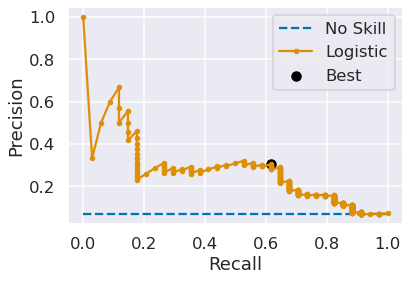

In [48]:
from sklearn.metrics import precision_recall_curve
from numpy import argmax

model = LogisticRegression()
model.fit(X_train_pca, y_train_re)

yhat = model.predict_proba(X_test)

yhat = yhat[:, 1]

# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_test, yhat)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
print('Reccall=%.3f, Precision=%.3f' % (recall[ix], precision[ix]))
# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show();


### Selected Models
After we have a baseline model, I included some popular classification models to find out which model stands out based on the metrics tailored to this problem. 

1. Logistic Regression
2. Support Vector Classification
3. Random Forest Classifier
4. Ada Boost Classifier
5. XG Boost Classifier
6. Naive Bayes

For now, I only showed the very basic models, as you can see there isn't much hyperparamters provided, most of them have default value, this is because later on I will select the models with better performance to fine tune. 

In [49]:
lr = LogisticRegression(random_state= 42)
svc = SVC(random_state= 42)
rf = RandomForestClassifier(random_state= 42)
ada = AdaBoostClassifier(random_state= 42)
xgb = XGBClassifier(random_state= 42)
gnb = GaussianNB()

In [50]:
def evaluation(model, X_train, Y_train, X_test, Y_test):
    metrics = {} 
    model.fit(X_train, Y_train)  # Training
    Y_pred = model.predict(X_test) # Predicts
    
    metrics['Accuracy_test'] = accuracy_score(Y_test , Y_pred)  
    
    metrics['Recall_test'] = recall_score(Y_test , Y_pred)
    
    metrics['Precision_test'] = precision_score(Y_test , Y_pred)
    
    metrics['F1_Score_test'] = f1_score(Y_test , Y_pred)
    
    metrics['5:1-Recall:Prec'] = (5*recall_score(Y_test , Y_pred)+1*precision_score(Y_test , Y_pred))/6
    
    return metrics

As shown above, only looking at Accuracy is not good enough, and sometimes even the F-1 score we obtained from changing threshold result in 0 recall and 0 precision or simply having a higher precision and lower recall. Although we always say that the recall and precision is a trade off, for this case we clearly care more about the false negative than false positive.

The formula for recall and precision are:

$$Recall = \frac{TP}{TP+FN}$$

$$Precision = \frac{TP}{TP+FP}$$

As mentioned in the problem description, it is 5 times worse than fail to predict a company going bankrupt than predicting a company bankrupt but it didn't. 

*False Negative*: Company bankrupt when the model shows it's a healthy company

*False Positive*: Model predict company bankrupt where the company is financially healthy.

With this in mind, I created a new metrics that has weighted False Negative and False Positive.

## Fit the Models

In [51]:
model_performance = {} # Initializing a dictionary to store training and testing data
for model in [lr, svc, rf, ada, xgb, gnb]: # these are our objects that we instantiated above. We loop through them
    model_name = model.__class__.__name__
    model_performance[model_name]  = {}
    model_performance[model_name] =  evaluation(model, X_train_pca, y_train_re, X_test, y_test)

[13:00:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### Evaluating the Models

In [52]:
pd.DataFrame(model_performance).T

,Accuracy_test,Recall_test,Precision_test,F1_Score_test,5:1-Recall:Prec
LogisticRegression,0.821577,0.647059,0.229167,0.338462,0.577410
SVC,0.883817,0.470588,0.296296,0.363636,0.441540
RandomForestClassifier,0.917012,0.029412,0.125000,0.047619,0.045343
AdaBoostClassifier,0.869295,0.441176,0.254237,0.322581,0.410020
XGBClassifier,0.896266,0.117647,0.166667,0.137931,0.125817
GaussianNB,0.597510,0.235294,0.045455,0.076190,0.203654


In [53]:
model_performance=pd.DataFrame(model_performance).T
model_performance['Recall_test'].sort_values(ascending=False)

LogisticRegression        0.647059
SVC                       0.470588
AdaBoostClassifier        0.441176
GaussianNB                0.235294
XGBClassifier             0.117647
RandomForestClassifier    0.029412
Name: Recall_test, dtype: float64

Based on the metrics, the following three models usually outperform the others
* Logistic Regression
* SVC
* Ada Boost

## Error Analysis

For the next part I will do Error Analysis to learn more about how these models failed using the confusion matrix.For simplicity, I only picked the two best performing models and the two worst model. I will plot the confusion matrix side by side. 

On the left hand side, we have the Logistic Regression and the SVC. On the right hand side, we have Naive Bayes and Random Forest.

### Confusion Matrix

In [54]:
def confusion(model,X_train,Y_train,X_test,Y_test):
    model.fit(X_train, Y_train)  # Training
    Y_pred = model.predict(X_test) # Predicts
    cm = confusion_matrix(Y_test,Y_pred)
    return cm

In [55]:
model_cm = {} # Initializing a dictionary to store training and testing data
for model in [lr, svc, rf, ada, xgb, gnb]: # these are our objects that we instantiated above. We loop through them
    model_name = model.__class__.__name__
    model_cm[model_name]  = {}
    model_cm[model_name] = confusion(model, X_train_pca, y_train_re, X_test, y_test)

[13:00:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


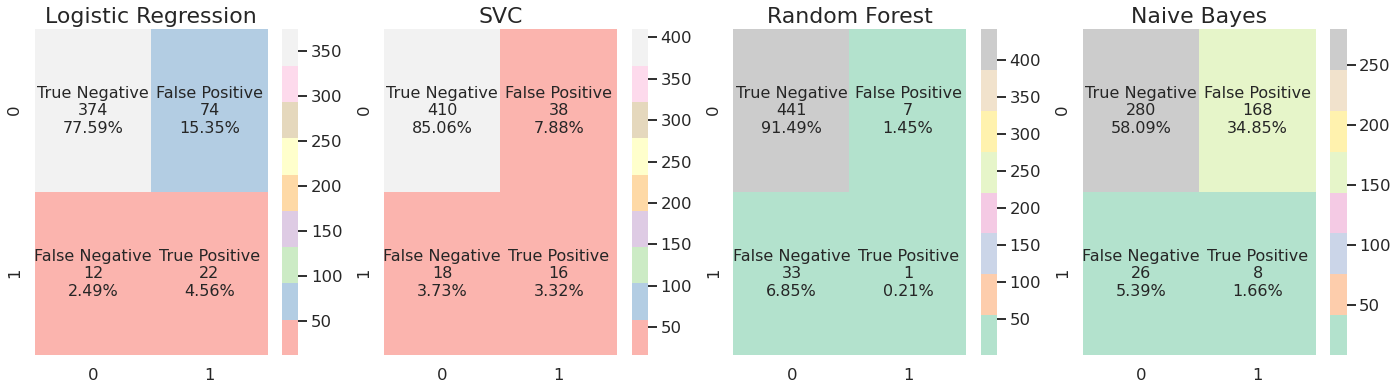

In [56]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(24, 6))

lgr = model_cm['LogisticRegression']
names =['True Negative','False Positive','False Negative','True Positive']
counts = ['{0:0.0f}'.format(value) for value in lgr.flatten()]
percent = ['{0:.2%}'.format(value) for value in lgr.flatten()/np.sum(lgr)]
show = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(names, counts, percent)]
show = np.asarray(show).reshape(2,2)
sns.heatmap(lgr,annot=show,fmt='',cmap='Pastel1',annot_kws={'size':16},ax=ax1);
ax1.set_title('Logistic Regression', fontsize=22)

svc_cm = model_cm['SVC']
names =['True Negative','False Positive','False Negative','True Positive']
counts = ['{0:0.0f}'.format(value) for value in svc_cm.flatten()]
percent = ['{0:.2%}'.format(value) for value in svc_cm.flatten()/np.sum(svc_cm)]
show = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(names, counts, percent)]
show = np.asarray(show).reshape(2,2)
sns.heatmap(svc_cm,annot=show,fmt='',cmap='Pastel1',annot_kws={'size':16},ax=ax2);
ax2.set_title('SVC', fontsize=22)

rfc = model_cm['RandomForestClassifier']
names =['True Negative','False Positive','False Negative','True Positive']
counts = ['{0:0.0f}'.format(value) for value in rfc.flatten()]
percent = ['{0:.2%}'.format(value) for value in rfc.flatten()/np.sum(rfc)]
show = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(names, counts, percent)]
show = np.asarray(show).reshape(2,2)
sns.heatmap(rfc,annot=show,fmt='',cmap='Pastel2',annot_kws={'size':16},ax=ax3);
ax3.set_title('Random Forest', fontsize=22)

gnb = model_cm['GaussianNB']
names =['True Negative','False Positive','False Negative','True Positive']
counts = ['{0:0.0f}'.format(value) for value in gnb.flatten()]
percent = ['{0:.2%}'.format(value) for value in gnb.flatten()/np.sum(gnb)]
show = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(names, counts, percent)]
show = np.asarray(show).reshape(2,2)
sns.heatmap(gnb,annot=show,fmt='',cmap='Pastel2',annot_kws={'size':16},ax=ax4);
ax4.set_title('Naive Bayes', fontsize=22)

plt.show();

The confusion matrix revealed that models with good performance(left hand side), are better at identifying true positives, the companies actually went bankrupt, and have lower false negative rate. Both Logistic Regression and SVC have about 2-3% False Negative cases in the entire testing data. 

However, the False Negative cases is two times in the Random Forest and Naive Bayes Models. These Models have higher false negative rate, they are twice more likely to fail to identify the bankrupt companies. On the other hand, the true positive rate is lower, as they correctly labeled less companies which are financially unstable and bankrupted. 

Adding penalty to the false negative and false positive case using 5* FN + 1* FP 
The numbers in confusion matrix varies, therefore the below numbers might not match with the current confusin matrix, but we still get some insights out of it

$$Logistic Regression = 5*15 + 1*84 = 159$$
$$SVC = 5*20 + 1*28 = 128$$
$$Random Forest = 5*29 + 1*5 = 150$$
$$Naive Bayes = 5*19 + 1*187 = 282$$

This new metrics shows that even when the recall of some model is lower, they might still be better. For example, under this metrics, random forest classifier actually outperforms the logistic regression. Although Random forest has higher false negative cases, its false positive cases is also significantly lower than other models.

so far, the best performance come from SVC, giving the lowest weighted number of cases.

## Fine-Tuning Models

Using Grid Search to tune the hyperparameters in each of the following models:

Note on the function I used, this function was created so I can play different refit scores(recall v precision) and see the difference in parameters. Since grid search takes quite some time to run I eventually didn't include this part in my code.

### Logistic Regression

In [57]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer

param_grid = {'C': [0.01, 0.1, 1, 2, 10, 100], 'penalty': ['l1', 'l2'],'solver':['newton-cg', 'lbfgs', 'liblinear'],'random_state':[42]}
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}
clf=LogisticRegression()
name='Logistic Regression(Fine Tuned)'

In [58]:
def grid_search_wrapper(refit_score='recall_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train_pca, y_train_re)

    # make the predictions
    y_pred = grid_search.predict(X_test)
    
    accuracy_test = accuracy_score(y_test,y_pred)
    recall_test = recall_score(y_test,y_pred)
    precision_test = precision_score(y_test,y_pred)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    print("\n Accuracy: {a:3.1%}, Recall {r:3.1%}, Precision {p:3.1%}".format(
                                                                            a=accuracy_test,
                                                                            r=recall_test,
                                                                            p=precision_test
                                                                            )
        )
    return grid_search

In [59]:
grid_search_clf = grid_search_wrapper(refit_score='recall_score')

Best params for recall_score
{'C': 100, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs'}

Confusion matrix optimized for recall_score on the test data:
     pred_neg  pred_pos
neg       375        73
pos        11        23

 Accuracy: 82.6%, Recall 67.6%, Precision 24.0%


$$Logistic Regression (Tuned) = 9*5 +160 = 205$$

After Tuning the Logistic Regression has about the same false negative numbers, but uses the new metrics the number went up instead of going down.Which is not something we like to see.

### Support Vector Classifier

In [60]:
param_grid = {'C': [0.01, 0.1, 1, 2, 10, 100],'gamma':[1,0.1,0.001,0.0001]}
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}
clf=svc
name='SVC(Fine Tuned)'

In [61]:
grid_search_clf = grid_search_wrapper(refit_score='recall_score')

Best params for recall_score
{'C': 100, 'gamma': 1}

Confusion matrix optimized for recall_score on the test data:
     pred_neg  pred_pos
neg       434        14
pos        34         0

 Accuracy: 90.0%, Recall 0.0%, Precision 0.0%


After tuning the SVC model's recall dropped to 0 because the 0 true positive. For some reason the SVC model have worse performance compared to before tuning. 

$$SVC(Tuned) = 30*5 + 25 = 175 $$

Using our own metrics, the SVC model is worse than before tuning, just like what happened to Logistic regression.

### Ada Boost

Ada Boost is actually the best in line after Logistic Regression and SVC. Ada Boost iteratively corrects the mistakes of the weak classifier and improves accuracy by combining weak learners. In addition, AdaBoost is not prone to overfitting. 

In [62]:
param_grid = {'n_estimators': [10,50,100],'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],'random_state': [42]}
clf=ada
name='Ada Boost(Fine Tuned)'

In [63]:
grid_search_clf = grid_search_wrapper(refit_score='recall_score')

Best params for recall_score
{'learning_rate': 0.0001, 'n_estimators': 10, 'random_state': 42}

Confusion matrix optimized for recall_score on the test data:
     pred_neg  pred_pos
neg       308       140
pos        11        23

 Accuracy: 68.7%, Recall 67.6%, Precision 14.1%


From Ada Boost's confusion matrix and metrics, we see that the recall for Ada Boost is not as high as the previous two models. 

$$ AdaBoost(Tuned) = 18*5 + 37 = 127 $$

Ada Boost actually provides a more balanced false positive and false negative, as the weighted count is much lower. From this perspective, the tuned Ada Boost is better than the tuned Logistic Regression and the SVC

### Random Forest Classifier

Finally, let's tune the random forest classifier. This one takes a while to run so I will put the conclusion up here. 
Random Forest Classifier perforamced about the same as the base model. The numbers in false positive and false negative are about the same with before. Although Random Forest is really good at lowering the false positive cases(the best in all models), the false negative is way to high. Another alarming thing is that the true positive is really low. Meaning that Random Forest Classifier only correctly identified the bankrupt company a few times.

In [64]:
param_grid={'n_estimators': [10, 50, 100], 'max_depth': [5, 8, 15, 25, 30],'min_samples_split': [2, 5, 10, 15, 100],'min_samples_leaf': [1, 2, 5, 10]}
clf = rf
name = 'Randome Forest (Tuned)'

In [65]:
grid_search_clf = grid_search_wrapper(refit_score='recall_score')

Best params for recall_score
{'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Confusion matrix optimized for recall_score on the test data:
     pred_neg  pred_pos
neg       441         7
pos        33         1

 Accuracy: 91.7%, Recall 2.9%, Precision 12.5%


$$Random Forest (Tuned) = 5*29 + 5 = 150 $$
Tuned Random Forest is on the same level as the Logistic regression before tuning.

### Select a model

Previously, I created a measure 5-1 Recall -Precision, which calculate a score that shows weighted recall & precision. However I realized how this might not be a good measure to replicate the rule that indicated in problem statement: false negative is 5 times worse than the false positive. 

Therefore, I used a new measure here:

$$New Metrics = 5*{False Negative} + False Positive$$

We use False Negative times 5 to penalize the inaccuracy in 
And we will see which model yield smaller measure. 

We will combine this measure with Recall to help selecting the best model, based on this metrics, the fine tuned logistic regression provides the lowest score, outperform other models. 

As shown before, using this measure, SVC and the random forest stands out because they have pretty lower count of this new metrics. 

If we are combining the recall,  precision, and accuracy score, Ada Boost is also a good choice. 
### Comparison of Models

#### SVC
Great recall score, slightly lower precision, good new metrics(weighted counts)

#### Random Forest
Poor recall, poor precision, high accuracy, good new metrics(weighted counts)

#### Ada Boost
Good recall and precision balance, alright accuracy alright new metrics(weighted counts)

### Decision and Reasoning
Ultimately, our model is about predicting the bankrupt ahead of time. Although under the new metrics Random Forest classification model shows really low false positive, it's not our best choice since it failed to identify company will poor financial condition more compared to other two models. 


For Support Vector Classification Model, this model is great in identifying company bankruptcy, however, we see that this is a trade off with precision, as many companies don't end up being bankrupted as SVC predicted. This will cause the investors/banks whoever using this model to miss out on investment opportunity because the SVC is extra cautious. Another point is that during the testing phase SVC sometimes would give 0 precision and 0 recall because the model has 0 true positive cases. (This happend 2-3 times)

Ada Boost Model is also great in a way that it really shows the balance between recall and precision. Yet under the new metrics we desgined, Ada Boost is not as good as SVC and Random Forest. Which is reasonable since each of the other model tends to either focus on lowering false positive or false negative. Ada Boost is a safer choice if we don't really have any preference on recall or precision.

However, we do know that for bankruptcy cases we really want to reduce the false negative and have a better recall. Therefore, I finally decided on using **Support Vector Model**. 

## Submission guidelines

Although your notebook may contain many models (e.g., due to your iterative development)
we will only evaluate a single model.
So choose one (explain why !) and do the following.

- You will implement the body of a subroutine `MyModel`
    - That takes as argument a Pandas DataFrame 
        - Each row is an example on which to predict
        - The features of the example are elements of the row
    - Performs predictions on each example
    - Returns an array or predictions with a one-to-one correspondence with the examples in the test set
    

We will evaluate your model against the holdout data
- By reading the holdout examples `X_hold` (as above)
- Calling `y_hold_pred = MyModel(X_hold)` to get the predictions
- Comparing the predicted values `y_hold_pred` against the true labels `y_hold` which are known only to the instructors

See the following cell as an illustration

**Remember**

The holdout data is in the same format as the one we used for training
- Except that it has no attribute for the target
- So you will need to perform all the transformations on the holdout data
    - As you did on the training data
    - Including turning the string representation of numbers into actual numeric data types

All of this work *must* be performed within the body of the `MyModel` routine you will write

We will grade you by comparing the predictions array you create to the answers known to us.

In [74]:

import pandas as pd
import os

def MyModel(X):
    # It should create an array of predictions; we initialize it to the empty array for convenience
    predictions = []
    
    # YOUR CODE GOES HERE
    X.set_index('Id')
    X = X.apply(pd.to_numeric, errors='coerce')
    X = pd.DataFrame(imputer.fit_transform(X),columns=X.columns)
    X.drop(['X37'], axis = 1,inplace=True)
    X = pd.DataFrame(trans.fit_transform(X),columns=X.columns)
    X = pd.DataFrame(pca.transform(X)).add_prefix('Component_')
    
#     clf = LogisticRegression(C=100,penalty='l1',solver='liblinear',random_state=0)
    svc=SVC(random_state= 42)
    clf = svc
    clf.fit(X_train_pca,y_train_re)
    predictions =clf.predict(X)
    
    return predictions



I had to define y_hold here in order to run this cell and all cells afters, otherwise it will show the y_hold is not defined and all other cells after can't run, so I get y_hold from the 5th_yr_with_target file, but I have never used it anywhere else.

# Final Test Result using holdout data

In [75]:
X_hold = pd.read_csv( os.path.join(DATA_DIR, "holdout", '5th_yr.csv') )

#since y_hold is in another file, I used the other file to define y_hold
hold = pd.read_csv( os.path.join(DATA_DIR, "holdout", '5th_yr_with_target.csv') )
y_hold = hold['Bankrupt']

# Predict using MyModel
y_hold_pred = MyModel(X_hold)

# Compute metrics
# accuracy
accuracy_hold = accuracy_score(y_hold, y_hold_pred)

# recall_
recall_hold = recall_score(y_hold, y_hold_pred, pos_label=1, average="binary")

# precision
precision_hold = precision_score(y_hold,   y_hold_pred, pos_label=1, average="binary")


print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Precision {p:3.1%}".format(m=name,
                                                                            a=accuracy_hold,
                                                                            r=recall_hold,
                                                                            p=precision_hold
                                                                            )
         )

	Fine Tuned Logistic Regression on Principal Components Accuracy: 87.5%, Recall 47.1%, Precision 36.6%


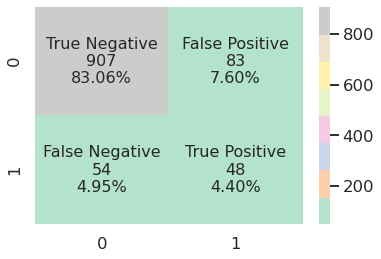

In [76]:
cm = confusion_matrix(y_hold,y_hold_pred)
lbs =['True Negative','False Positive','False Negative','True Positive']
counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
percent = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
show = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(names, counts, percent)]
show = np.asarray(show).reshape(2,2)
sns.heatmap(cm,annot=show,fmt='',cmap='Pastel2',annot_kws={'size':16});

# Check your work: predict and evaluate metrics on *your* test examples

Although only the instructors have the correct labels for the holdout dataset, you may want
to create your own test dataset on which to evaluate your out of sample metrics.

If you choose to do so, you can evaluate your models using the same metrics that the instructors will use.

- Test whether your implementation of `MyModel` works
- See the metrics  your model produces

In [77]:
name = "Fine Tuned Logistic Regression on Principal Components"
y_test_pred = MyModel(test_data_copy)

accuracy_test = accuracy_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred, pos_label=1, average="binary")
precision_test = precision_score(y_test,   y_test_pred, pos_label=1, average="binary")

print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Precision {p:3.1%}".format(m=name,
                                                                            a=accuracy_test,
                                                                            r=recall_test,
                                                                            p=precision_test
                                                                            )
        )

	Fine Tuned Logistic Regression on Principal Components Accuracy: 88.4%, Recall 47.1%, Precision 29.6%


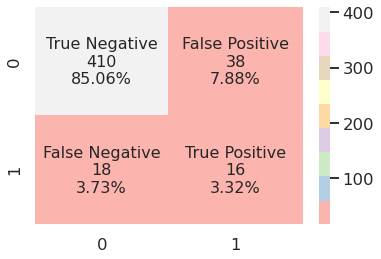

In [78]:
cm = confusion_matrix(y_test,y_test_pred)
lbs =['True Negative','False Positive','False Negative','True Positive']
counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
percent = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
show = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(names, counts, percent)]
show = np.asarray(show).reshape(2,2)
sns.heatmap(cm,annot=show,fmt='',cmap='Pastel1',annot_kws={'size':16});